In [53]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

%matplotlib inline

# Exploratory Data Analysis

First let us read the data into a pandas DataFrame.

In [29]:
data = pd.read_excel('data.xlsx')

In [30]:
print 'Number of samples: ', data.shape[0]

Number of samples:  296


It will be useful to isolate the columns which deal with scores.  We will also clean up the column label by removing the trailing '_17' in each score field.

In [31]:
score_cols = [col for col in data.columns if 'score' in col]

# Replace trailing '_17' in label
for i in range(len(score_cols)):
    data.rename(columns={score_cols[i]: score_cols[i][:-3]}, inplace=True)
    score_cols[i] = score_cols[i][:-3]

## Data Completeness

First let us visualize the frequency counts of the score labels to see how complete the data is.

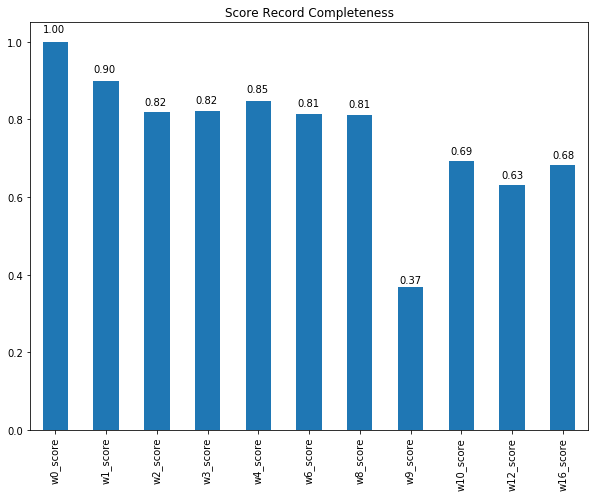

In [32]:
ax = (data[score_cols].count()/data.shape[0]).plot(kind='bar', title='Score Record Completeness', figsize=(10,7.5))
for p in ax.patches:
    ax.annotate(str(format(p.get_height(), '.2f')), (p.get_x() * 1.005, p.get_height() * 1.025))

Next let's plot the distribution of row completeness with respect to w0 to w8 scores.  For example, how many rows have data for all 7 of the trials.

In [33]:
first_trial_scores = score_cols[:7]  # w0 to w8
data['valid_scores'] = data[first_trial_scores].notnull().sum(axis=1)

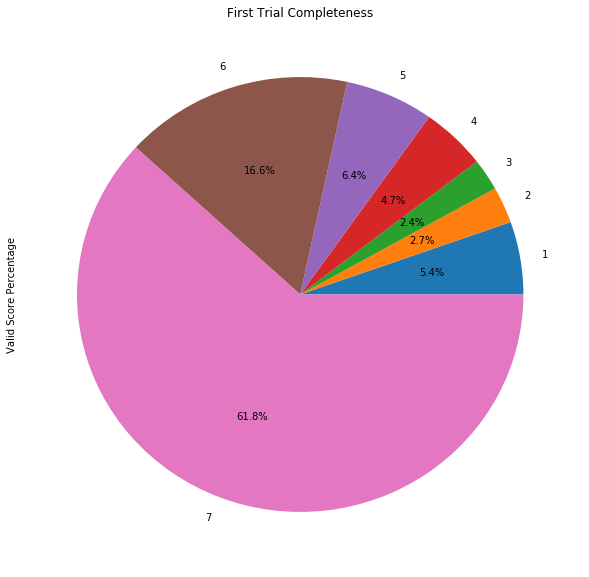

In [34]:
pd.Series(data.groupby(['valid_scores']).size()/data.shape[0], name="Valid Score Percentage").plot(kind='pie', autopct='%1.1f%%', title='First Trial Completeness', figsize=(10,10))

## Score Distributions

Next we will investigate the distribution of scores over each scoring period with respect to the entire dataset.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1aa32090>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a1b13aed0>]], dtype=object)

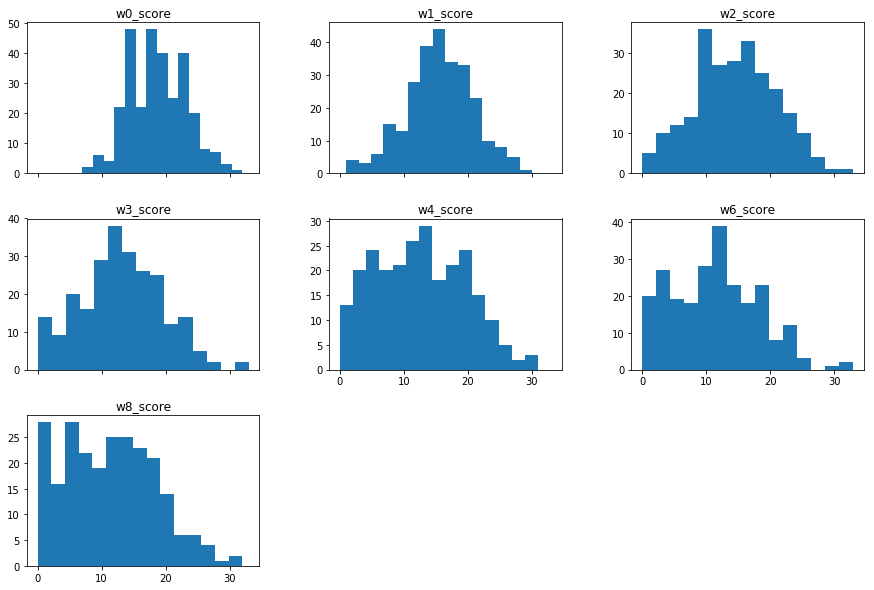

In [35]:
data.hist(column=first_trial_scores, grid=False, figsize=(15,10), bins=15, sharex=True)

The histograms above align with our prior beliefs about the domain.  As the weeks progress we see a shift in the distributions towards a right skewed shape.  This shows that many of the patients are in remission.

### Population Score Distribution

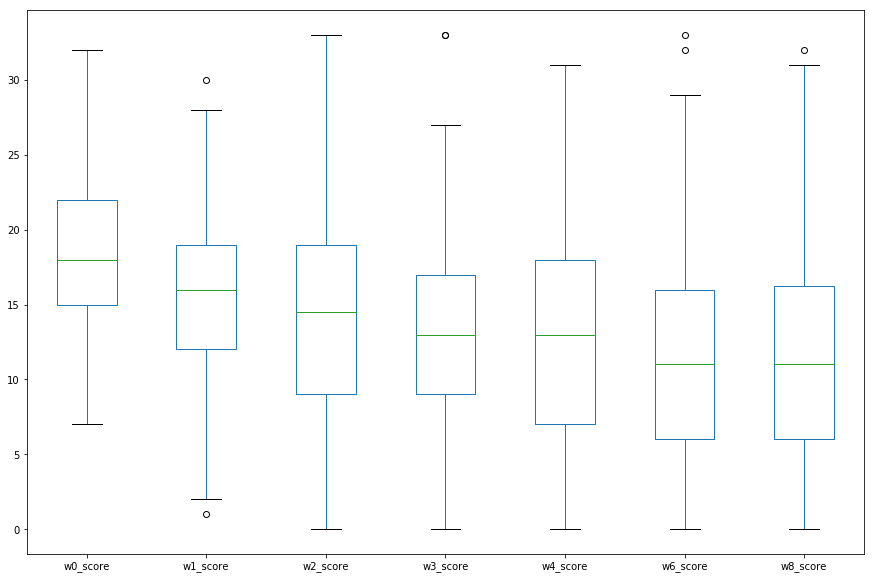

In [36]:
data.boxplot(column=first_trial_scores, grid=False, figsize=(15,10))

### Effective Treatment Score Distribution

At this point we should investigate the distributions conditioned on the class label (effective vs. ineffective).  We will use the assumption that a Hamilton score of $\leq 10$ on week 8 indicates that the treatment was effective.  Effective treatment will be labeled 1, ineffective treatment 0.

In [37]:
data['label'] = data.apply(lambda row: 1 if row.w8_score <= 10 else 0, axis=1)

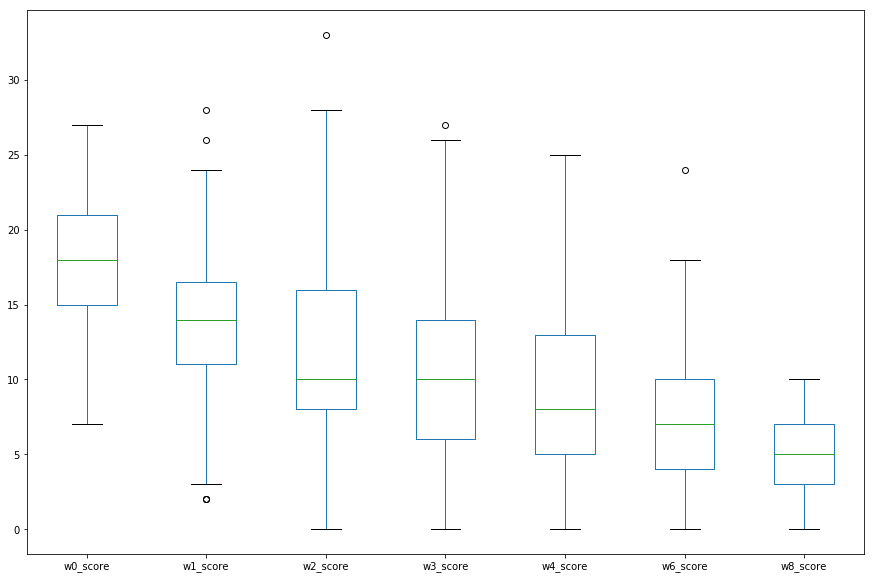

In [38]:
data.loc[data['label'] == 1].boxplot(column=first_trial_scores, grid=False, figsize=(15,10))

### Ineffective Treatment Score Distribution

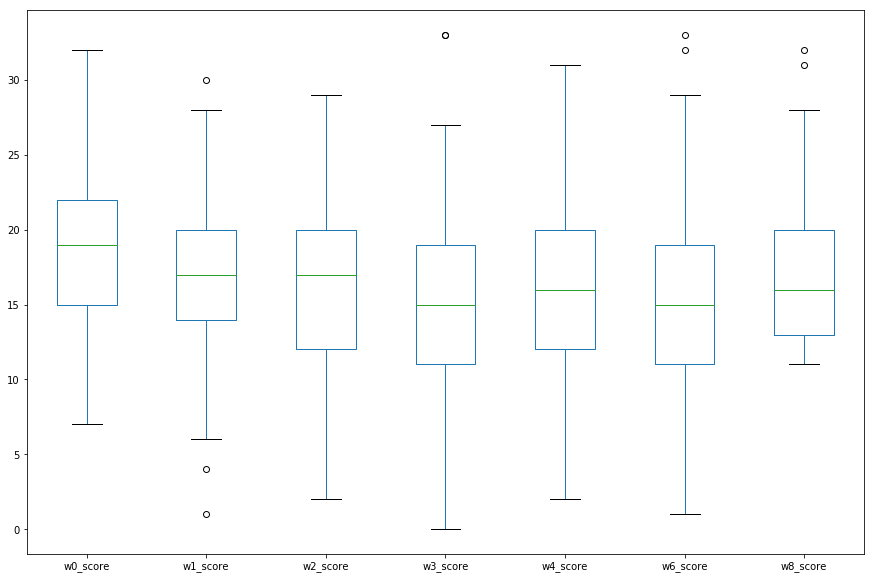

In [39]:
data.loc[data['label'] == 0].boxplot(column=first_trial_scores, grid=False, figsize=(15,10))

It seems clear that there is a difference in the distributions over time conditioned on the effectiveness of the treatment.  When the treatment is effective we see a steady decrease in the median Hamilton score.  Ineffective cases have median fluctuation which is likely attributed to noise.

### SER Score Distribution

Next let's see how the distributions vary based on the treatment type.

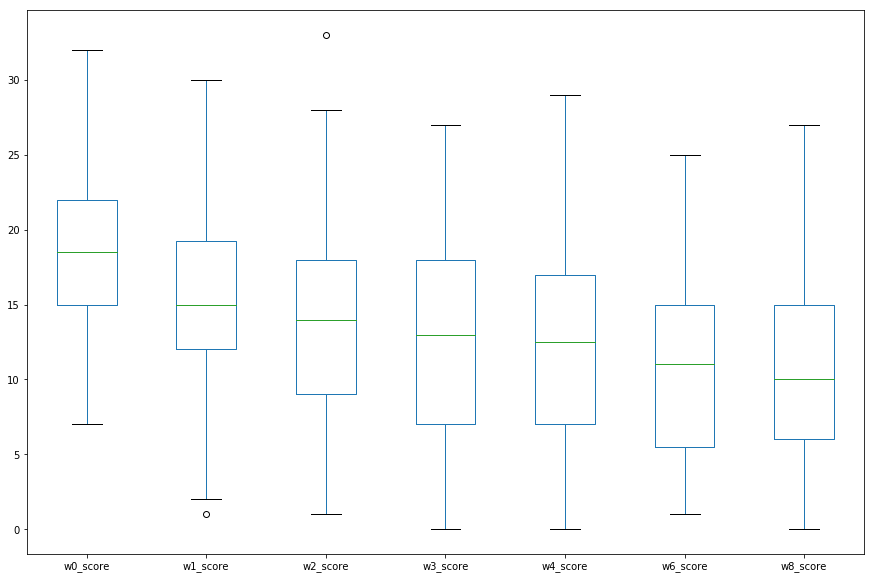

In [40]:
data.loc[data['Stage1TX'] == 'SER'].boxplot(column=first_trial_scores, grid=False, figsize=(15,10))

### PLA Score Distribution

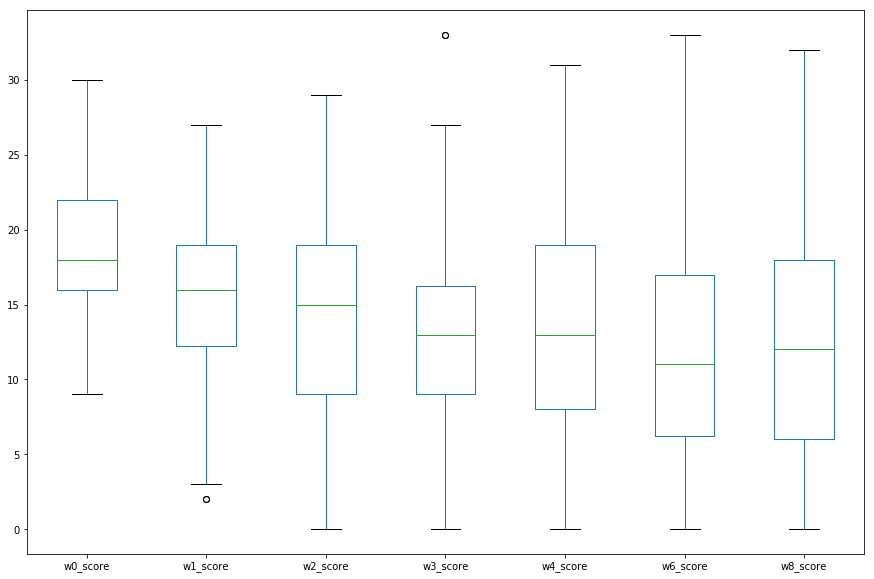

In [41]:
data.loc[data['Stage1TX'] == 'PLA'].boxplot(column=first_trial_scores, grid=False, figsize=(15,10))

The distributions with respect to treatment type do not seem to differ in a pronounced manner.

### Scorce Distributions by Effectiveness and Treatment Type

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1c0ad950>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a1c411650>]], dtype=object)

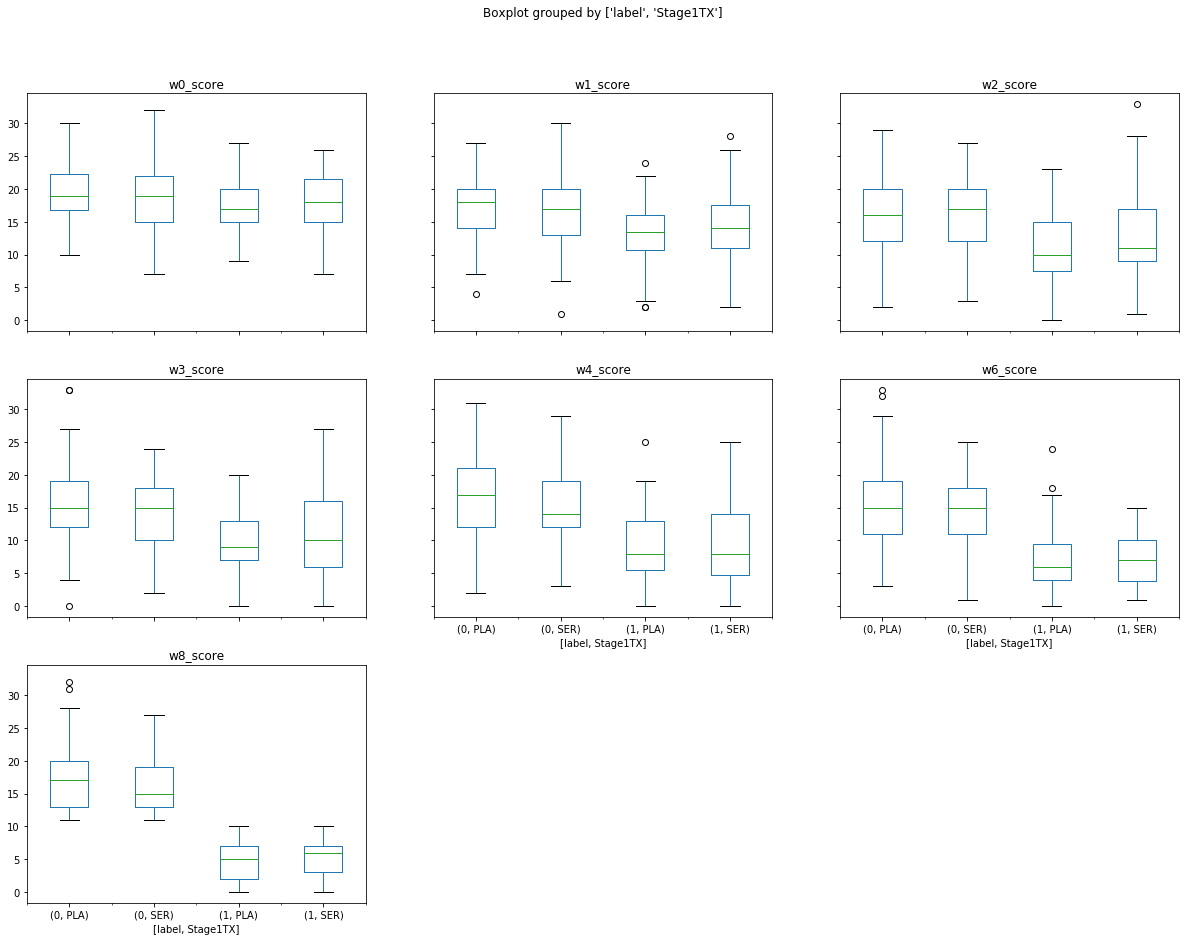

In [42]:
data.boxplot(column=first_trial_scores, by=['label', 'Stage1TX'], grid=False, figsize=(20,15))

Observing the distributions grouped by both treatment and outcome we see that there is a noticable difference between the outcome group distributions.  

One possible artifact of the missing values is that the outcome label is entirely determined by the w8_score.  However this field has 19% missing data.  All of these subjects would be labeled as negative, although their prior trends may reflect a positive outcome.  This can be observed in the many low valued Hamilton scores in the negative class even up to week 6.

### Mean and Variance of Scores

Text(0.5,1,u'Ineffective Treatment Mean and Variance of Scores')

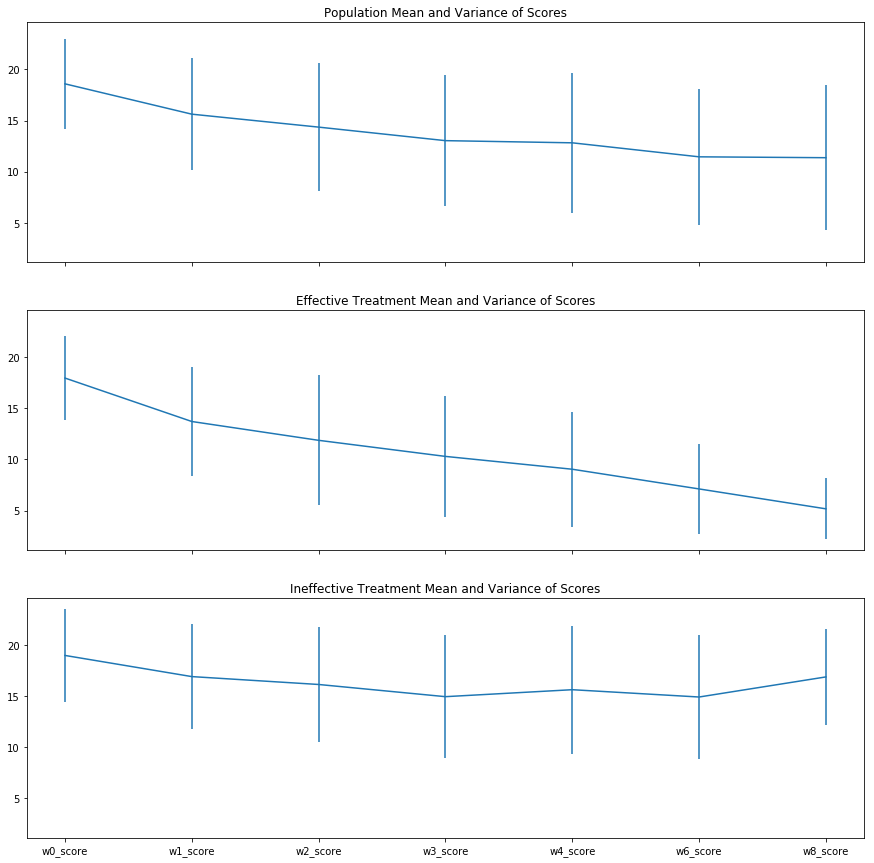

In [43]:
fig, ax = plt.subplots(3, sharex=True, sharey=True, figsize=(15,15))
plt.figure(figsize=(25,20))

errors = data[first_trial_scores].std()
ax[0].errorbar(first_trial_scores, data[first_trial_scores].mean(), errors)
ax[0].set_title('Population Mean and Variance of Scores')

errors = data.loc[data['label'] == 1][first_trial_scores].std()
ax[1].errorbar(first_trial_scores, data.loc[data['label'] == 1][first_trial_scores].mean(), errors)
ax[1].set_title('Effective Treatment Mean and Variance of Scores')

errors = data.loc[data['label'] == 0][first_trial_scores].std()
ax[2].errorbar(first_trial_scores, data.loc[data['label'] == 0][first_trial_scores].mean(), errors)
ax[2].set_title('Ineffective Treatment Mean and Variance of Scores')

# Data Cleaning

We will consider rows which have at least 4 valid scores for the first trial period for cleaning.  Data points which have less than 4 valid scores will be discarded.

In [44]:
interpolated_data = data.loc[data['valid_scores'] > 3].copy()

We will use pandas interpolate() function as a baseline imputation method.  Having done imputation we then recompute the labels for the rows.

In [45]:
interpolated_data[first_trial_scores] = interpolated_data[first_trial_scores].interpolate(axis=1)
interpolated_data['label'] = interpolated_data.apply(lambda row: 1 if row.w8_score <= 10 else 0, axis=1)

We should see how the frequency of positive and negative cases has changed.

In [46]:
print 'Original data:\n', data.loc[data['valid_scores'] > 3]['label'].value_counts()
print '\nInterpolated data:\n', interpolated_data['label'].value_counts()

Original data:
0    152
1    113
Name: label, dtype: int64

Interpolated data:
0    139
1    126
Name: label, dtype: int64


As shown above 13 negative classes are now labeled as positive.  The incorrect labeling was an artifact of the missing week 8 score.

## Score Distributions

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1c8e9a50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a1d405a90>]], dtype=object)

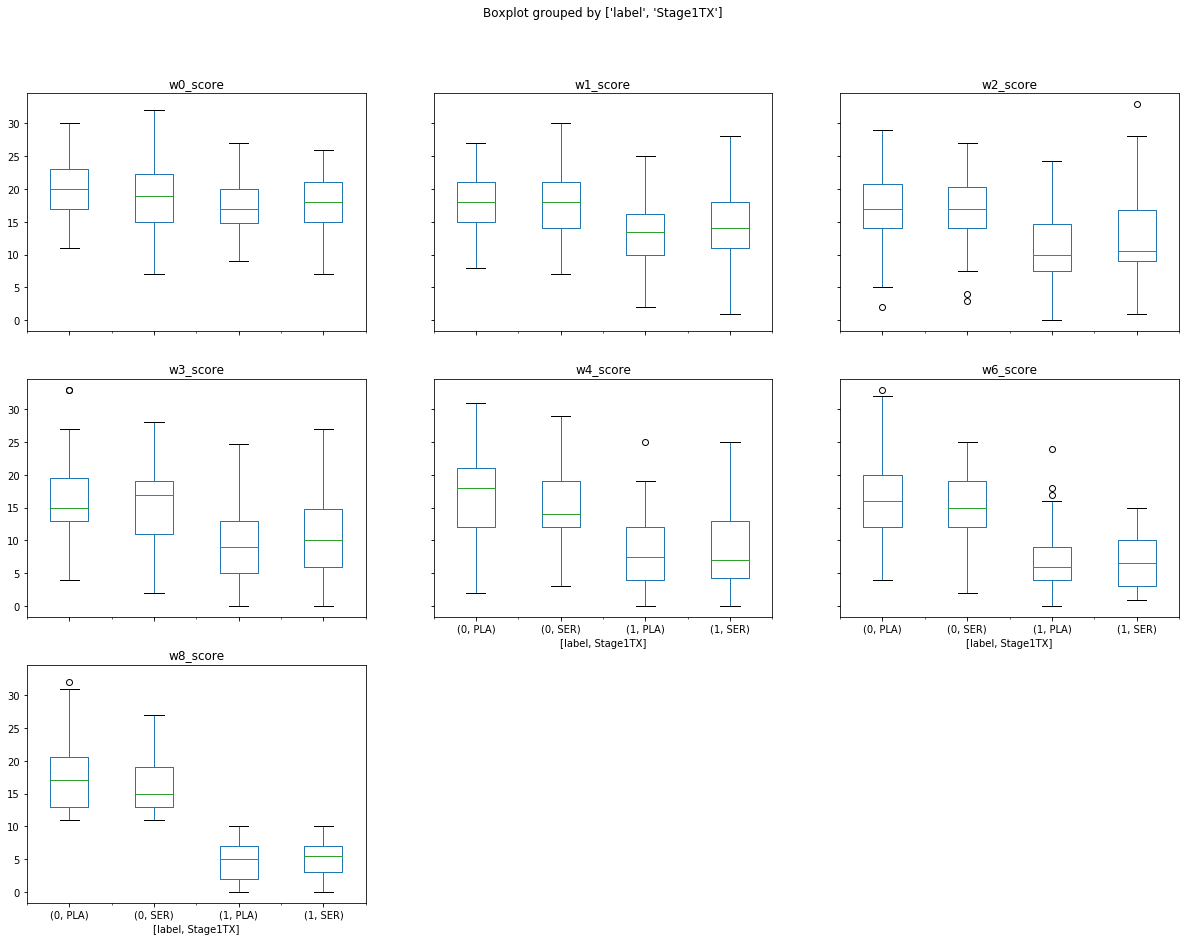

In [47]:
interpolated_data.boxplot(column=first_trial_scores, by=['label', 'Stage1TX'], grid=False, figsize=(20,15))

Text(0.5,1,u'Ineffective Treatment Mean and Variance of Scores')

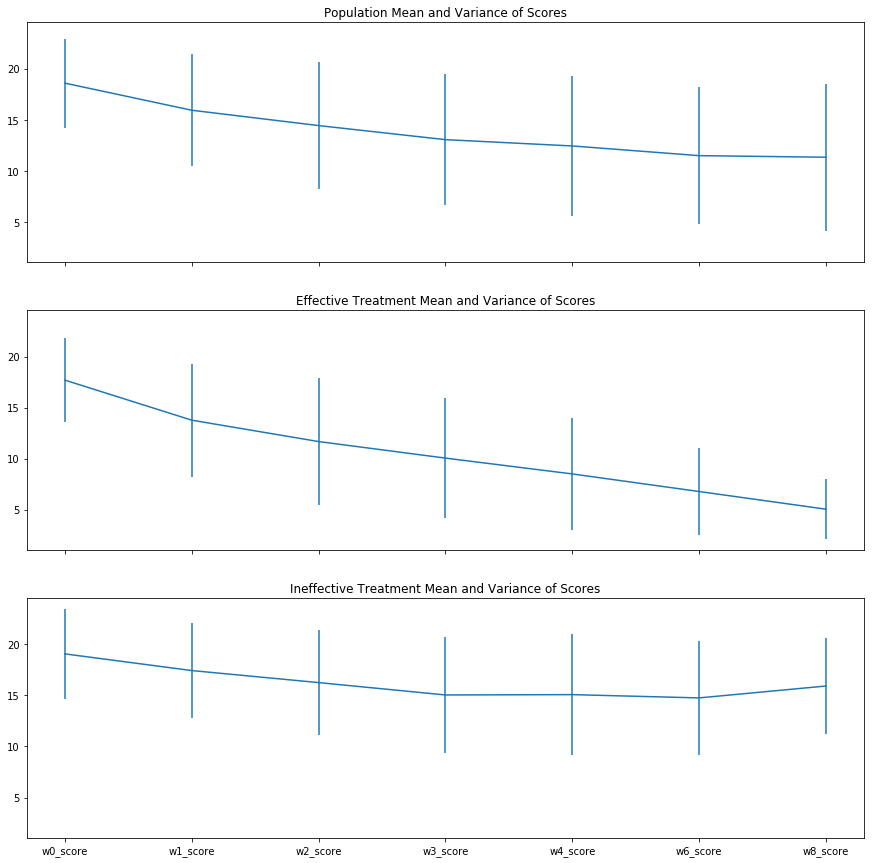

In [48]:
fig, ax = plt.subplots(3, sharex=True, sharey=True, figsize=(15,15))
plt.figure(figsize=(25,20))

errors = interpolated_data[first_trial_scores].std()
ax[0].errorbar(first_trial_scores, interpolated_data[first_trial_scores].mean(), errors)
ax[0].set_title('Population Mean and Variance of Scores')

errors = interpolated_data.loc[interpolated_data['label'] == 1][first_trial_scores].std()
ax[1].errorbar(first_trial_scores, interpolated_data.loc[interpolated_data['label'] == 1][first_trial_scores].mean(), errors)
ax[1].set_title('Effective Treatment Mean and Variance of Scores')

errors = interpolated_data.loc[interpolated_data['label'] == 0][first_trial_scores].std()
ax[2].errorbar(first_trial_scores, interpolated_data.loc[data['label'] == 0][first_trial_scores].mean(), errors)
ax[2].set_title('Ineffective Treatment Mean and Variance of Scores')

We see that the box plots and mean/variance distributions have not changed significantly after imputation.  The box plots are slightly tighter in the quartiles with less pronoinced outliers.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1d8febd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a1e371250>]], dtype=object)

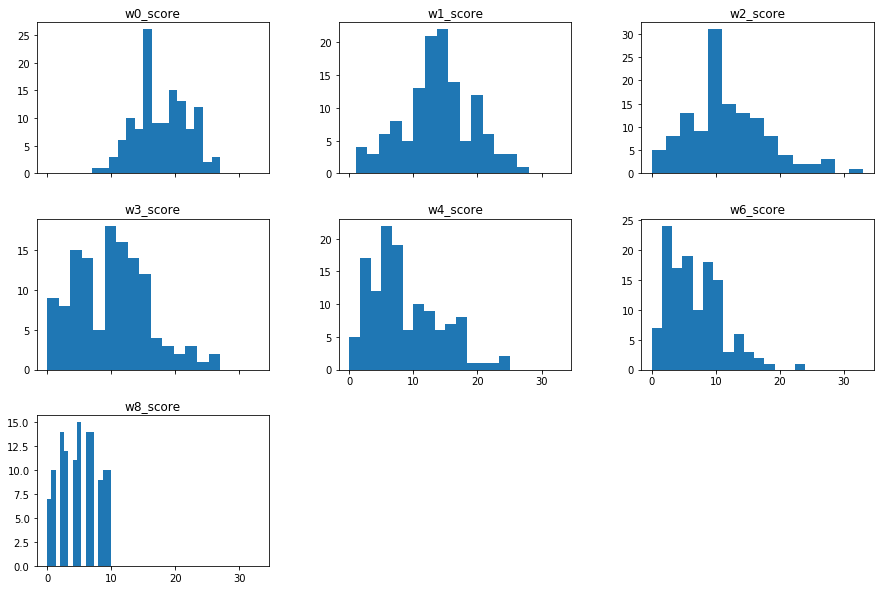

In [49]:
interpolated_data.loc[interpolated_data['label'] == 1].hist(column=first_trial_scores, grid=False, figsize=(15,10), bins=15, sharex=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1e63e390>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a1ea39390>]], dtype=object)

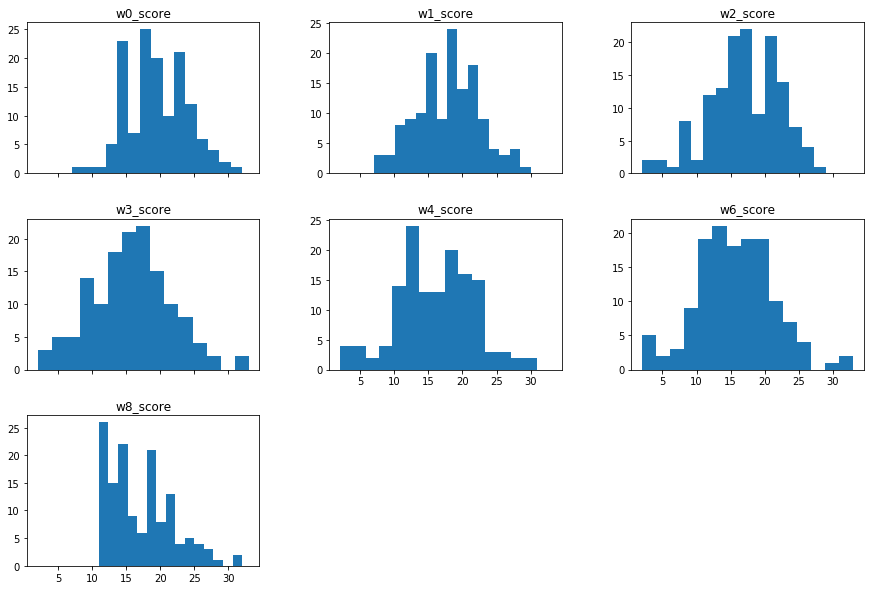

In [50]:
interpolated_data.loc[interpolated_data['label'] == 0].hist(column=first_trial_scores, grid=False, figsize=(15,10), sharex=True, bins=15)

The score histograms conditioned on the outcome label show noticably different distributions which become increasingly distinct as the weeks progress.

## Data Normalization

We will apply z-score normalization to the input data.

In [56]:
scaler = StandardScaler()
scaler.fit(interpolated_data[first_trial_scores])
interpolated_data[first_trial_scores] = scaler.transform(interpolated_data[first_trial_scores])

First we will split our data into an 80/20 train/test split.

In [59]:
X_train, X_test, y_train, y_test = train_test_split(interpolated_data[first_trial_scores], interpolated_data['label'], test_size=0.2, random_state=42)

## Logistic Regression

In [61]:
logistic = LogisticRegression()
print('LogisticRegression score: %f' % logistic.fit(X_train, y_train).score(X_test, y_test))

LogisticRegression score: 0.943396
